# Analyse Spatial Patterns in Classifications

In [30]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

In [13]:
def plot_rose(ax, indicators, lsoa_code, color):
    this_lsoa = indicators[indicators['LSOA11CD'] == lsoa_code]
    this_lsoa.reset_index(inplace=True, drop=True)
    del this_lsoa['LSOA11CD']
    del this_lsoa['LA_NAME']
    del this_lsoa['gentrification_prediction_code']
    this_lsoa_T = this_lsoa.T
    this_lsoa_T.reset_index(inplace=True)
    this_lsoa_T = this_lsoa_T.rename(columns={0: 'scores'})
    # E01014485_T['max_vals'] = max_vals[0].values
    df = this_lsoa_T.copy()
    # df['pct'] = df['scores'] / df['max_vals']
    df = df.set_index('index')
    
    # Replace NaN values with 0 in the plot data (but keep NaNs in the DataFrame)
    df['scores_for_plot'] = df['scores'].fillna(0)
    
    # Recalculate N and angles after replacing NaNs
    N = df.shape[0]
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    
    # Assign new angles
    df['radar_angles'] = theta
    
    # Plot
    ax.bar(df['radar_angles'], df['scores_for_plot'], width=2 * np.pi / N, linewidth=2, edgecolor='k', alpha=0.6, color=color)
    
    # Adjust labels (keeping original categories with NaNs)
    ax.set_xticks(theta)
    ax.set_xticklabels(df.index)
    ax.set_yticklabels([])

### Get gentrification scores

In [14]:
city='melbourne'
central_suburbs = gpd.read_file(f"../../../data/SpatialData/MelbourneSuburbs.shp")

In [44]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
gentrification_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_01.csv')

In [45]:
gentrification_df['geometry'] = gentrification_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gentrification_gdf = gpd.GeoDataFrame(gentrification_df, geometry='geometry', crs="EPSG:4326")

In [46]:
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
gentrification_gdf['gentrification_prediction_code'] = gentrification_gdf['gentrification_prediction'].map(mapping)

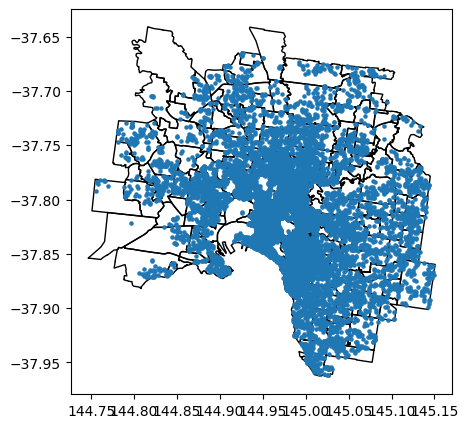

In [47]:
fig, ax = plt.subplots(figsize=(8,5))
central_suburbs.plot(ax=ax, edgecolor = 'black', facecolor='none'), 
gentrification_gdf.plot(ax=ax,  markersize=5);

### Get summary score for each suburb

In [48]:
gentrification_gdf = gentrification_gdf.merge(
    index[['SAL_NAME21', 'Classification']],
    on='SAL_NAME21',
    how='left'  # or 'inner' if you only want matching rows
)
per_listing = gentrification_gdf[['Classification', 'gentrification_prediction_code']]


In [49]:
suburb_scores_gentrification = gentrification_gdf.groupby("SAL_NAME21")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
suburb_scores_gentrification_df = pd.DataFrame(suburb_scores_gentrification)
suburb_scores_gentrification_df.reset_index(inplace=True)

suburb_counts_gentrification = gentrification_gdf.groupby("SAL_NAME21")["gentrification_prediction_code"].count()
suburb_counts_gentrification_df = pd.DataFrame({'count': suburb_counts_gentrification})
suburb_counts_gentrification_df.reset_index(inplace=True)

suburb_scores_gentrification_df = suburb_scores_gentrification_df.merge(suburb_counts_gentrification_df, on='SAL_NAME21', how='outer')

In [50]:
central_suburbs = central_suburbs.merge(suburb_scores_gentrification_df, on='SAL_NAME21', how='left')

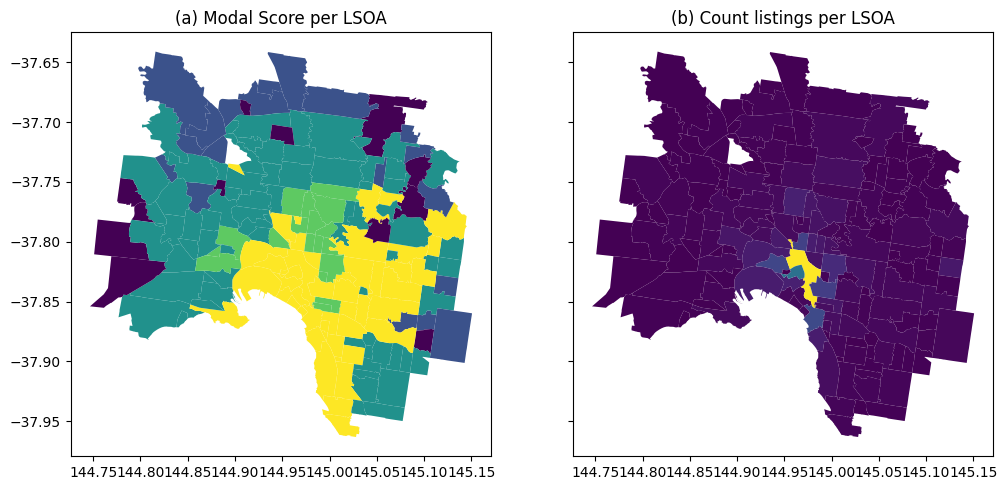

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]}, sharey=True, sharex=True)  # Ensure equal subplot sizes
central_suburbs.plot('gentrification_prediction_code', ax=axs[0])
axs[0].set_title("(a) Modal Score per LSOA")
central_suburbs.plot('count', ax=axs[1]);
axs[1].set_title("(b) Count listings per LSOA");
plt.tight_layout()
fig.subplots_adjust(wspace=-0.2)

### Compare to the index

In [39]:
index = pd.read_csv(f"../../../data/GentrificationIndex/MelbourneIndex/Edited.csv")
scores_and_index = suburb_scores_gentrification_df.merge(index, on='SAL_NAME21', how='left')

SAL_NAME21  gentrification_prediction_code  count  \
0      Abbotsford (Vic.)                             3.0    234   
1             Aberfeldie                             2.0      3   
2           Airport West                             1.0     25   
3     Albert Park (Vic.)                             4.0    111   
4          Albion (Vic.)                             2.0     17   
..                   ...                             ...    ...   
163  Williamstown (Vic.)                             4.0    131   
164   Williamstown North                             2.0      6   
165       Windsor (Vic.)                             3.0    198   
166            Yallambie                             1.0      5   
167           Yarraville                             3.0    118   

     Classification                                           geometry  \
0               8.0  POLYGON ((145.00195118200008 -37.7966457799999...   
1               8.0  POLYGON ((144.89575927400006 -37.7651372929999...   
2               6.0  POLYGON ((144.87978911200003 -37.7156533309999...   
3               8.0  POLYGON ((144.95444585600012 -37.8379375969999...   
4               4.0  POLYGON ((144.82393228500007 -37.7764921979999...   
..              ...                                                ...   
163             8.0  POLYGON ((144.89464700500002 -37.8509660629999...   
164             6.0  POLYGON ((144.85795038100002 -37.8538151199999...   
165             8.0  POLYGON ((144.99337696700002 -37.8518371799999...   
166             8.0  POLYGON ((145.10068192200004 -37.7270678459999...   
167             8.0  POLYGON ((144.88986405000003 -37.8097659919999...   

     classification_new  
0                   3.0  
1                   3.0  
2                   2.0  
3                   3.0  
4                   1.0  
..                  ...  
163                 3.0  
164                 2.0  
165                 3.0  
166                 3.0  
167                 3.0  

[168 rows x 6 columns]

### Drop the NA scores for the LLM cats

In [23]:
# scores_and_index = scores_and_index[scores_and_index['gentrification_prediction_code']!=0]

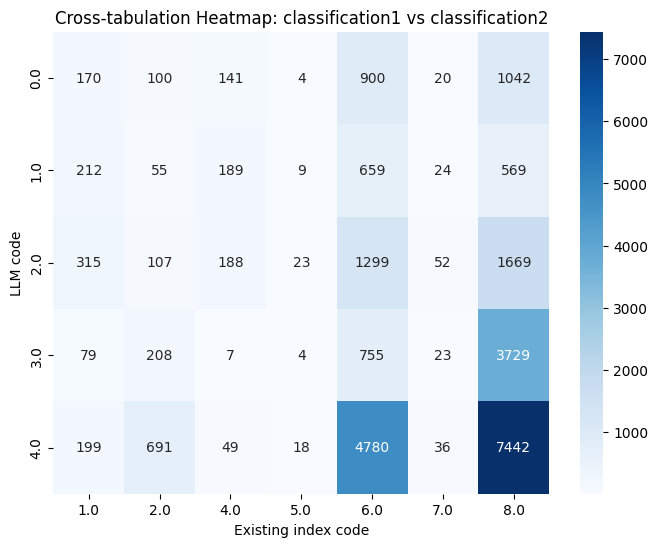

In [52]:
# Cross-tabulation
crosstab = pd.crosstab(per_listing['gentrification_prediction_code'], per_listing['Classification'])

plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Cross-tabulation Heatmap: classification1 vs classification2')
plt.xlabel('Existing index code')
plt.ylabel('LLM code')
plt.show()

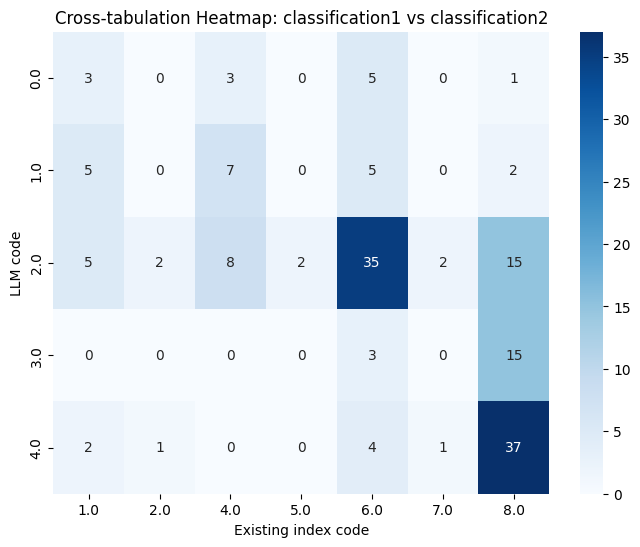

In [24]:
# Cross-tabulation
crosstab = pd.crosstab(scores_and_index['gentrification_prediction_code'], scores_and_index['Classification'])

plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Cross-tabulation Heatmap: classification1 vs classification2')
plt.xlabel('Existing index code')
plt.ylabel('LLM code')
plt.show()


### Normalised to show the percentage of values in that row in each column

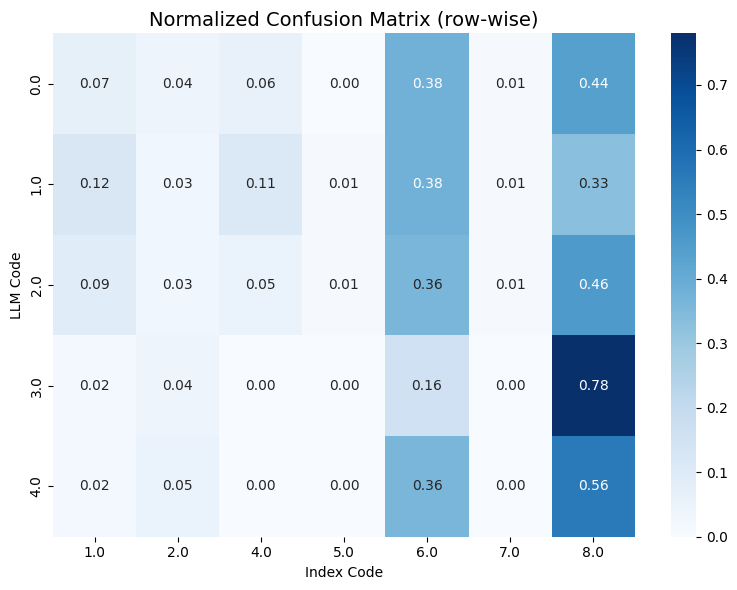

In [53]:
crosstab = pd.crosstab(per_listing['gentrification_prediction_code'], per_listing['Classification'])
normalized = crosstab.div(crosstab.sum(axis=1), axis=0).round(2)
plt.figure(figsize=(8, 6))
sns.heatmap(normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.title('Normalized Confusion Matrix (row-wise)', fontsize=14)
plt.xlabel('Index Code')
plt.ylabel('LLM Code')
plt.tight_layout()
plt.show()

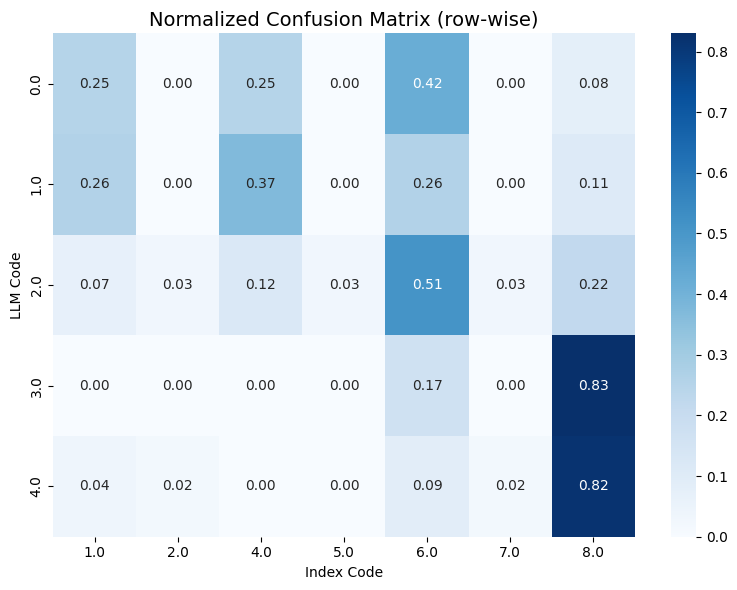

In [25]:
crosstab = pd.crosstab(scores_and_index['gentrification_prediction_code'], scores_and_index['Classification'])
normalized = crosstab.div(crosstab.sum(axis=1), axis=0).round(2)
plt.figure(figsize=(8, 6))
sns.heatmap(normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.title('Normalized Confusion Matrix (row-wise)', fontsize=14)
plt.xlabel('Index Code')
plt.ylabel('LLM Code')
plt.tight_layout()
plt.show()


In [26]:
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Cross-tabulation
crosstab = pd.crosstab(scores_and_index['gentrification_prediction_code'], scores_and_index['Classification'])

# Optional: ensure square structure
all_classes = sorted(set(scores_and_index['gentrification_prediction_code']) |
                     set(scores_and_index['Classification']))
# crosstab = crosstab.reindex(index=all_classes, columns=all_classes, fill_value=0)


In [27]:
chi2, p, dof, expected = chi2_contingency(crosstab) 
# Pearson residuals = (observed - expected) / sqrt(expected)
residuals = (crosstab - expected) / (expected ** 0.5)

In [28]:
# Convert to dict with tuple keys: (LLM, Index)
mosaic_data = {
    (str(int(i)), str(int(j))): crosstab.loc[i, j]
    for i in crosstab.index
    for j in crosstab.columns
}

# Color mapping based on residuals
def props(key):
    i, j = int(key[0]), int(key[1])
    r = residuals.loc[i, j]
    # blue for positive residuals, red for negative, white ~ no deviation
    if r > 1.96:
        return {'color': '#2166ac'}  # strong positive
    elif r < -1.96:
        return {'color': '#b2182b'}  # strong negative
    else:
        return {'color': '#f7f7f7'}  # not significant


In [62]:
# Suppose these are all possible categories (adjust as needed)
all_predictions = per_listing['gentrification_prediction_code'].unique()
all_classifications = all_classifications = np.arange(1, 9) 

# Create full cartesian product of all pairs
full_index = pd.MultiIndex.from_product(
    [all_predictions, all_classifications],
    names=['gentrification_prediction_code', 'Classification']
)

# Group and count as you did
mosaic_df = (
    per_listing
    .groupby(['gentrification_prediction_code', 'Classification'])
    .size()
    .reindex(full_index, fill_value=0)  # fill missing pairs with 0 count
    .reset_index(name='count')
)
# Rename columns
mosaic_df.columns = ['Prediction', 'Classification', 'count']
mosaic_df = mosaic_df.sort_values((['Prediction', 'Classification']))

# Then pivot, etc.
table = mosaic_df.pivot_table(index='Prediction', columns='Classification', values='count', aggfunc='sum', fill_value=0)
table

Classification    1    2  3    4   5     6   7     8
Prediction                                          
0.0             170  100  0  141   4   900  20  1042
1.0             212   55  0  189   9   659  24   569
2.0             315  107  0  188  23  1299  52  1669
3.0              79  208  0    7   4   755  23  3729
4.0             199  691  0   49  18  4780  36  7442

In [63]:
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic

# Define a color for each classification column
classification_colors = {
    '1': '#d73027',
    '2': '#fc8d59',
    '3': '#fee08b',
    '4': '#d9ef8b',
    '5': '#91cf60',
    '6': '#1a9850',
    '7': '#4575b4',
    '8': '#313695'
}
def props(key):
    classification = str(key[1])  # column key
    color = classification_colors.get(classification, '#f0f0f0')  # fallback color
    return {'color': color}


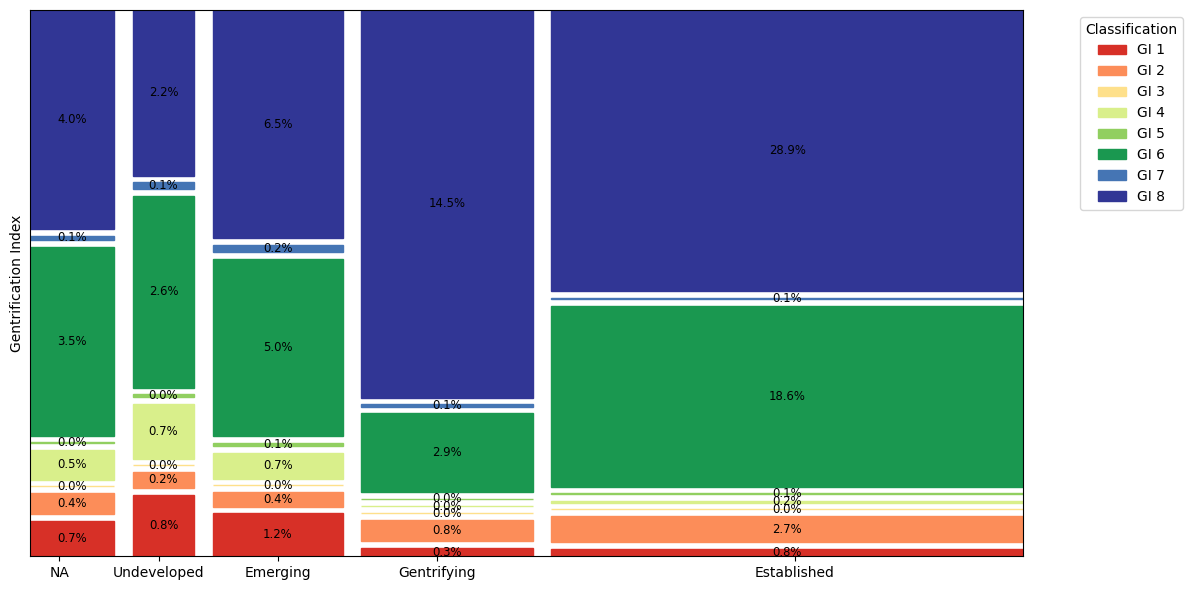

In [68]:
mosaic_data = {
    (str(row), str(col)): table.loc[row, col]
    for row in table.index
    for col in table.columns}

# Total for percent labels
total = sum(mosaic_data.values())

# Label function
def labelizer(key):
    pct = mosaic_data[key] / total * 100
    return f"{pct:.1f}%"

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
mosaic(
    mosaic_data,
    labelizer=labelizer,
    gap=0.02, axes_label=False, properties=props, ax=ax)

legend_patches = [
    mpatches.Patch(color=color, label=f'GI {cls}')
    for cls, color in classification_colors.items()]

plt.legend(
    handles=legend_patches,
    title='Classification',
    bbox_to_anchor=(1.05, 1),
    loc='upper left')

# Extract x/y categories from data
x_labels = mosaic_df['Prediction'].unique()
x_labels = ['NA', 'Undeveloped', 'Emerging', 'Gentrifying', 'Established']
y_labels = mosaic_df['Classification'].unique()

# Set axis ticks manually (adjust positions if necessary)
# ax.set_xticks([i / len(x_labels) + 0.5 / len(x_labels) for i in range(len(x_labels))])
ax.set_xticks([0.03,0.13,0.25,0.41,0.77])
ax.set_xticklabels(x_labels, rotation=0)
# ax.set_yticks([i / len(y_labels) + 0.5 / len(y_labels) for i in range(len(y_labels))])
# ax.set_yticklabels(y_labels)

# Add axis titles
# ax.set_xlabel('Classification from LLM')
ax.set_ylabel('Gentrification Index')

plt.tight_layout()
plt.show()
